# **Assignment 1**

##Clustering on Spotify Tracks Dataset 🎶


### 👥 Team Members
- Djossa
- Caraccio
- Quaranta


In [89]:
import kagglehub
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy import stats
import statsmodels.stats.multitest as smm
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sns.set_style("whitegrid")
sns.set_palette("Set2")

# **1. The Dataset**

We download the Spotify Tracks dataset from Kaggle.

##Feature types:
- **Categorical feature:** `genre`  
- **Binary feature:** `mode`  
- **Numerical features:** `danceability`, `energy`, `speechiness`, `acousticness`, `popularity`, `liveness`, `valence`, `duration_ms`


In [90]:
# ---------------------------------------------
# 1. Download dataset from Kaggle
# ---------------------------------------------
path = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")
print("Path to dataset files:", path)

# Most KaggleHub datasets include one or more CSVs -> let's find the right one
for file in os.listdir(path):
    print("Found file:", file)

# Load the main file
df = pd.read_csv(os.path.join(path, "SpotifyFeatures.csv"))
print("\nShape of the dataset:", df.shape)
#print(df.head())

Using Colab cache for faster access to the 'ultimate-spotify-tracks-db' dataset.
Path to dataset files: /kaggle/input/ultimate-spotify-tracks-db
Found file: SpotifyFeatures.csv

Shape of the dataset: (232725, 18)


## **2. Feature Selection and Sampling**

From the full dataset, we randomly select **1000 tracks** to simplify computation and visualization.

**Data preparation steps:**
- **Selected features:** `genre`, `danceability`, `energy`, `speechiness`, `acousticness`, `popularity`, `liveness`, `valence`, `duration_ms`, `mode`
- **Sampling:** 1000 random tracks   
- **Binary conversion:** converted `mode` → 1 (*Major*), 0 (*Minor*)  
- **Categorical encoding:** one-hot encoding applied to `genre`  
- **Standardization:** scaled all numerical and binary features.




In [91]:
# ---------------------------------------------
# 2. Selection and sampling (1000 tracks)
# ---------------------------------------------
df_sample = df.sample(n=1000, random_state=0)
print("\nShape of the sampled dataset:", df_sample.shape)

# Selection of features of interest
features = [
    'genre', 'danceability', 'energy', 'speechiness', 'acousticness',
    'popularity', 'liveness', 'valence', 'duration_ms', 'mode'
]

X = df_sample[features].dropna()

# Binary conversion
# Ensure 'mode' is numeric before further processing
if X['mode'].dtype == 'object':
    X['mode'] = X['mode'].map({'Major': 1, 'Minor': 0}).astype(int)


# ---------------------------------------------
#  Separation by variable type
# ---------------------------------------------
categorical_features = ['genre']
binary_features = ['mode'] # 'mode' is now numeric (0 or 1)
numeric_features = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'popularity', 'liveness', 'valence', 'duration_ms'
]


X['genre_orig'] = X['genre'] # keep the original for chi-square
# One-hot encoding for 'genre'
X_cat = pd.get_dummies(X[categorical_features], prefix=categorical_features)

# Standardization only for numeric features
scaler = StandardScaler()
# Combine numeric and binary features for scaling, as 'mode' is now numeric
features_to_scale = numeric_features + binary_features
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[features_to_scale]),
    columns=features_to_scale
)

# Let's combine all parts: numeric + binary + categorical
# X_num_scaled now includes the scaled 'mode' column
X_final = pd.concat(
    [X_num_scaled.reset_index(drop=True),
     X_cat.reset_index(drop=True)],
    axis=1
)

# Create a new X DataFrame containing only the numeric and one-hot encoded features
X = pd.concat(
    [X[numeric_features + binary_features].reset_index(drop=True), # Use original numeric and binary features (now numeric)
     X_cat.reset_index(drop=True),
     X['genre_orig'].reset_index(drop=True)],
    axis=1
)

print("\n✅ Dataset ready for clustering!")
print("Final shape:", X_final.shape)
print("First columns:", X_final.columns[:15].tolist())
print("\nShape of DataFrame X for visualizations:", X.shape)

# Standardized matrix (numpy) for K-Means
X_scaled = X_final.values


Shape of the sampled dataset: (1000, 18)

✅ Dataset ready for clustering!
Final shape: (1000, 36)
First columns: ['danceability', 'energy', 'speechiness', 'acousticness', 'popularity', 'liveness', 'valence', 'duration_ms', 'mode', 'genre_A Capella', 'genre_Alternative', 'genre_Anime', 'genre_Blues', "genre_Children's Music", 'genre_Children’s Music']

Shape of DataFrame X for visualizations: (1000, 37)


## **3. Initial Feature Visualization**

Before applying clustering, we explore the dataset to understand how the features are distributed.

**Visual analyses:**
- **Distributions:**  
  Histograms show the distribution of each numerical feature  
  
  The categorical feature `genre` is displayed using a count plot.  

- **Correlation heatmap:**  
  Displays the relationships between numerical features.  
  This helps to identify which variables are strongly correlated  
  and may influence the clustering process.


📊 Distribution of audio features before clustering:



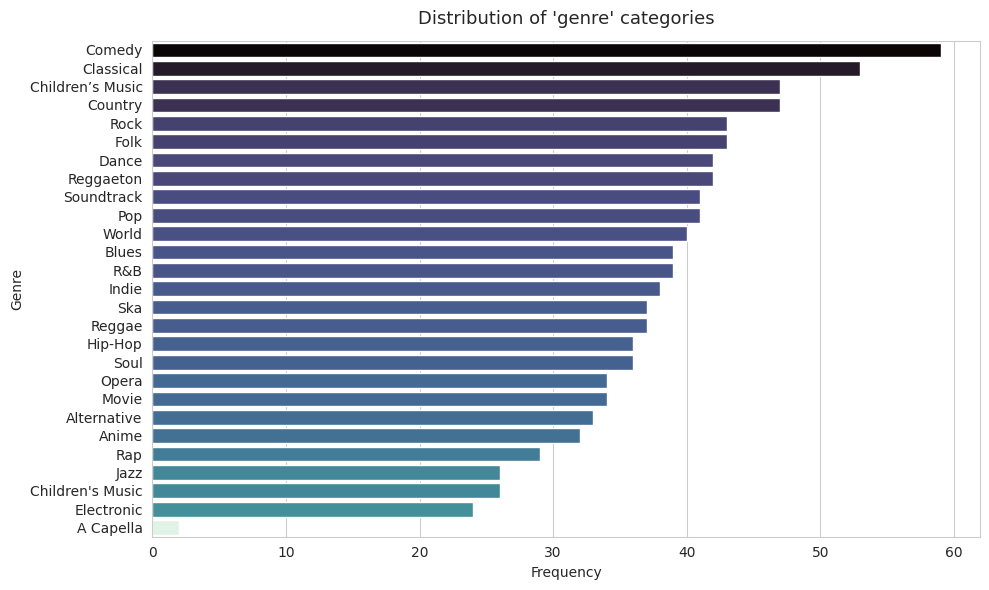

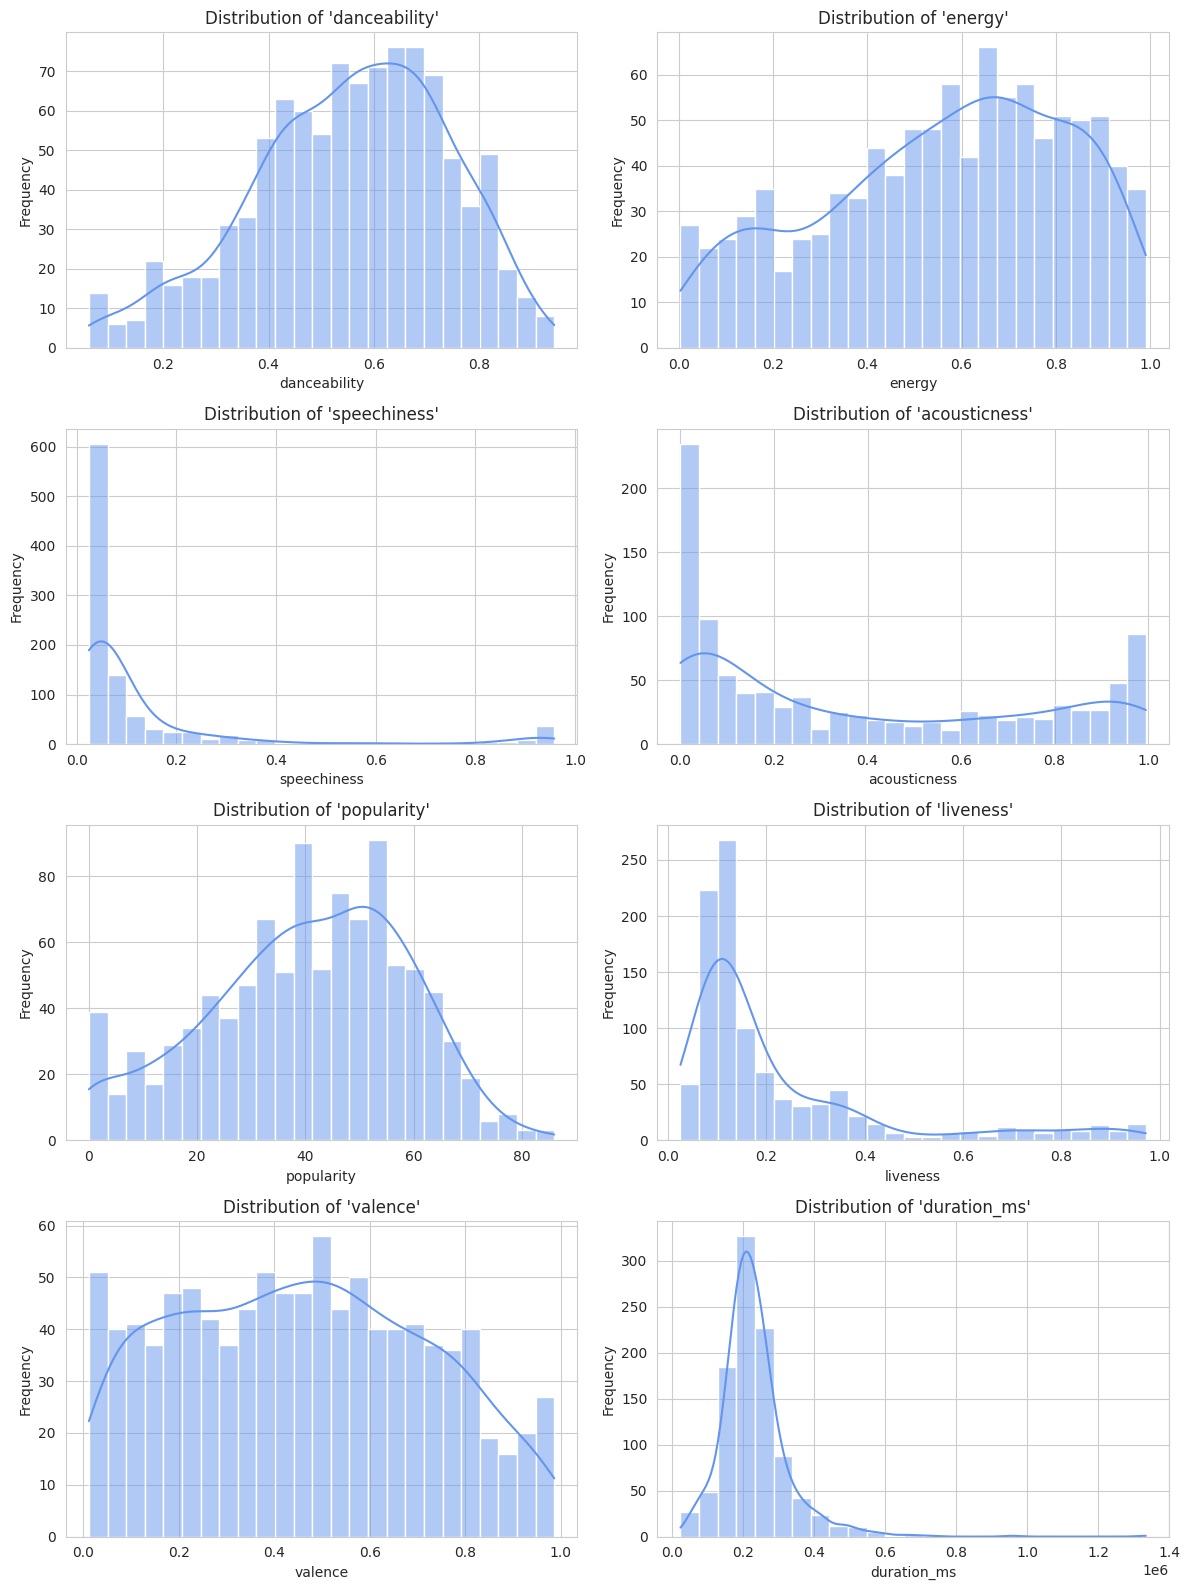

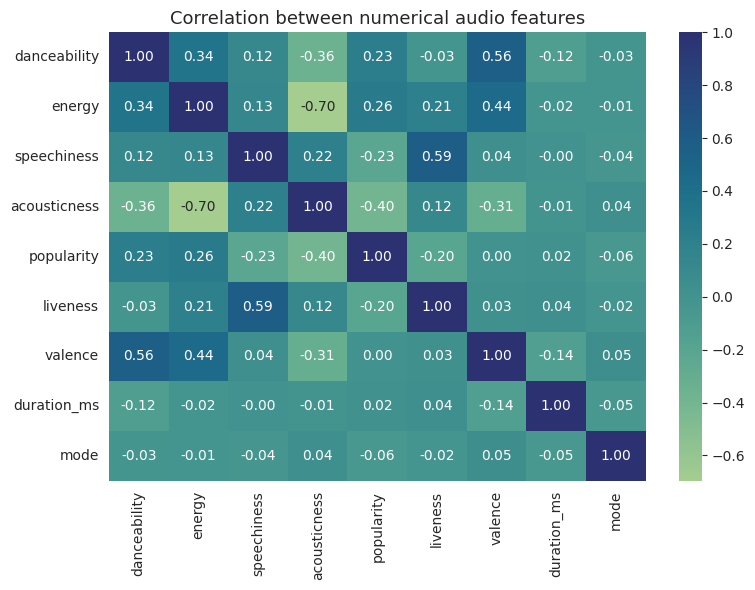

In [92]:
# ---------------------------------------------
# 3. Initial feature visualization (improved layout)
# ---------------------------------------------
sns.set_style("whitegrid")
sns.set_palette("Set2")

print("📊 Distribution of audio features before clustering:\n")

# ----- Genre plot -----
counts = df_sample["genre"].value_counts().reset_index()
counts.columns = ["genre", "count"]

plt.figure(figsize=(10, 6))
sns.barplot(
    y="genre",
    x="count",
    data=counts,
    palette=sns.color_palette("mako_r", as_cmap=True),
    hue="count",
    dodge=False,
    legend=False
)
plt.title("Distribution of 'genre' categories", fontsize=13, pad=12)
plt.xlabel("Frequency")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# ----- Numeric feature distributions -----
numeric_features = [
    "danceability", "energy", "speechiness", "acousticness",
    "popularity", "liveness", "valence", "duration_ms"
]

n_cols = 2
n_rows = int(np.ceil(len(numeric_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.histplot(
        X[col],
        kde=True,
        bins=25,
        color="cornflowerblue",
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of '{col}'", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Remove any unused subplot spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# ---------------------------------------------
#  Correlation between numerical features (Heatmap)
# ---------------------------------------------
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

if len(numeric_cols) > 1:
    plt.figure(figsize=(8, 6))
    corr = X[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='crest', fmt=".2f")
    plt.title("Correlation between numerical audio features", fontsize=13)
    plt.tight_layout()
    plt.show()


## **4. Finding the Best Number of Clusters (k)**

We test `k` from **2 to 9** to find the optimal number of clusters.  

**Metrics used:**  
- **Inertia (Elbow Method):**
- **Silhouette Score:**
- **Davies–Bouldin Index:**  
- **Calinski–Harabasz Index:**  

**Goal:** Identify a `k` that balances cluster compactness and separation.  



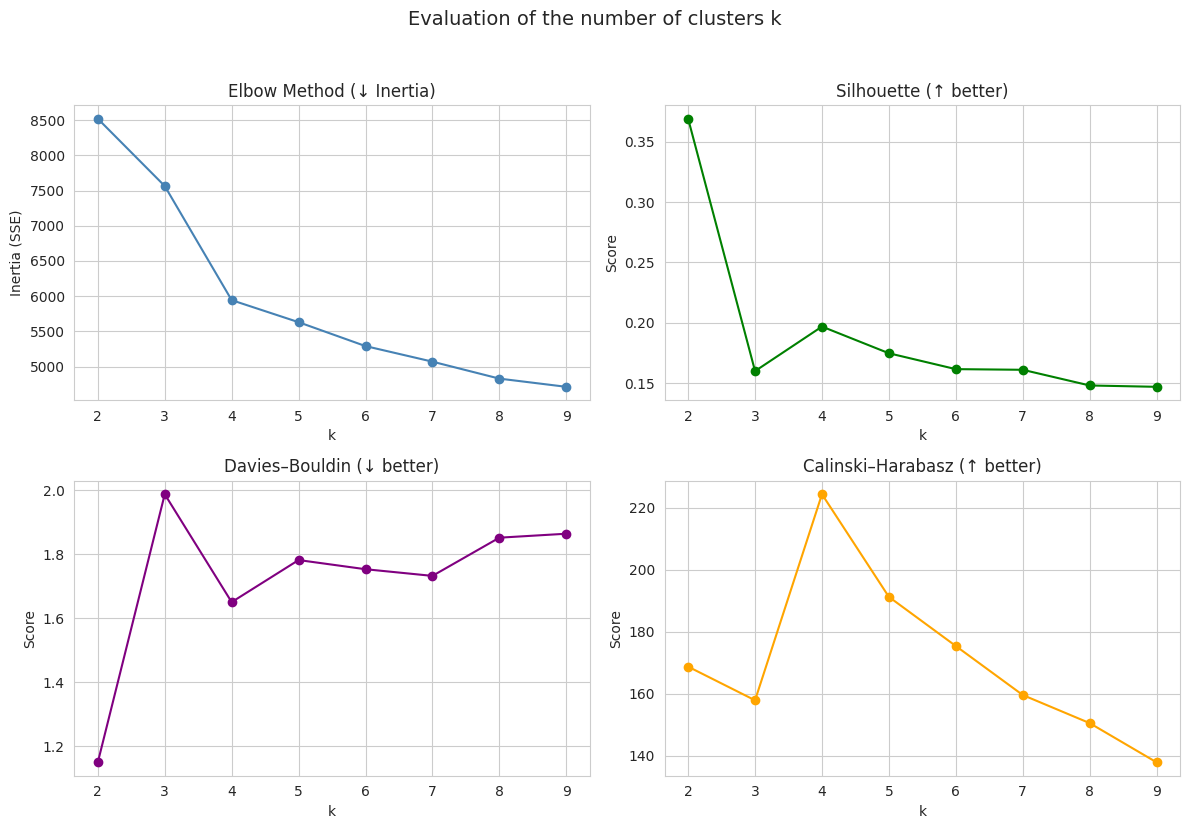

In [93]:
# ---------------------------------------------
# Find the best number of clusters (k)
# ---------------------------------------------
K = range(2, 10)
inertias = []
silhouette_scores = []
db_scores = []
ch_scores = []

for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_scaled)

    # Evaluation metrics
    inertias.append(km.inertia_)  # sum of intra-cluster distances
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))

# ---------------------------------------------
# Comparative plots (including Elbow)
# ---------------------------------------------
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Elbow Method
axs[0,0].plot(K, inertias, 'o-', color='steelblue')
axs[0,0].set_title("Elbow Method (↓ Inertia)")
axs[0,0].set_xlabel("k")
axs[0,0].set_ylabel("Inertia (SSE)")
axs[0,0].grid(True)

# Silhouette
axs[0,1].plot(K, silhouette_scores, 'o-', color='green')
axs[0,1].set_title("Silhouette (↑ better)")
axs[0,1].set_xlabel("k")
axs[0,1].set_ylabel("Score")
axs[0,1].grid(True)

# Davies–Bouldin
axs[1,0].plot(K, db_scores, 'o-', color='purple')
axs[1,0].set_title("Davies–Bouldin (↓ better)")
axs[1,0].set_xlabel("k")
axs[1,0].set_ylabel("Score")
axs[1,0].grid(True)

# Calinski–Harabasz
axs[1,1].plot(K, ch_scores, 'o-', color='orange')
axs[1,1].set_title("Calinski–Harabasz (↑ better)")
axs[1,1].set_xlabel("k")
axs[1,1].set_ylabel("Score")
axs[1,1].grid(True)

plt.suptitle("Evaluation of the number of clusters k", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

## **5. Comparing Two Elbow Methods**

To refine the choice of `k`, we compare **two Elbow detection methods**:

1. **Successive Differences:**  
   Finds the point where the drop in inertia slows down.

2. **Geometric Distance:**  
   Selects the point with the maximum perpendicular distance from a line connecting the first and last inertia values.




⭐ Best k according to Elbow (Successive Differences): 6
⭐ Best k according to Elbow (Geometric Distance): 4


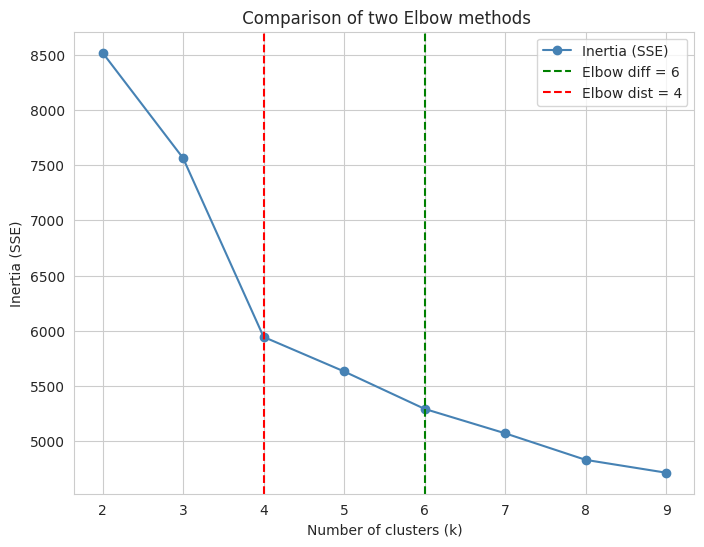

In [94]:
# ---------------------------------------------
# 🔍 Comparison between two Elbow methods
# ---------------------------------------------
import math
import numpy as np

# Method 1: Successive differences
def elbow_diff_method(k_vals, inertias):
    diff_inertias = np.diff(inertias)
    ratios = np.abs(diff_inertias[1:] / diff_inertias[:-1])
    # the elbow is where the drop slows down (ratio close to 1)
    best_k = k_vals[np.argmin(np.abs(ratios - 1)) + 2]
    return best_k

# Method 2: Maximum distance from the line segment
def detect_elbow_distance(k_vals, inertias):
    p1x, p1y = k_vals[0], inertias[0]
    p2x, p2y = k_vals[-1], inertias[-1]
    dists = []
    for k, val in zip(k_vals, inertias):
        px, py = k, val
        num = abs((p2x - p1x) * (p1y - py) - (p2y - p1y) * (p1x - px))
        den = math.hypot(p2x - p1x, p2y - p1y)
        dists.append(num / den if den != 0 else 0.0)
    elbow_idx = int(np.argmax(dists))
    return int(k_vals[elbow_idx]), dists

# Calculate both
best_k_el_diff = elbow_diff_method(K, inertias)
best_k_el_dist, dists = detect_elbow_distance(K, inertias)

print(f"⭐ Best k according to Elbow (Successive Differences): {best_k_el_diff}")
print(f"⭐ Best k according to Elbow (Geometric Distance): {best_k_el_dist}")

# ---------------------------------------------
# 🔹 Comparative visualization
# ---------------------------------------------
plt.figure(figsize=(8,6))
plt.plot(K, inertias, 'o-', color='steelblue', label='Inertia (SSE)')
plt.axvline(best_k_el_diff, color='green', linestyle='--', label=f"Elbow diff = {best_k_el_diff}")
plt.axvline(best_k_el_dist, color='red', linestyle='--', label=f"Elbow dist = {best_k_el_dist}")
plt.title(" Comparison of two Elbow methods")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.legend()
plt.grid(True)
plt.show()

# # (Optional) Also show the distance curve for method 2
# plt.figure(figsize=(7,4))
# plt.plot(K, dists, 'o-', color='darkorange')
# plt.title("📏 Perpendicular distance from the segment (geometric method)")
# plt.xlabel("k")
# plt.ylabel("Distance from the line segment")
# plt.grid(True)
# plt.show()

## **6. Selection of the Best k and Final Clustering**

We combine multiple metrics and methods to **select the optimal number of clusters (`k`)**:

- **Silhouette Score:** chooses the `k` with the highest score  
- **Davies–Bouldin Index:** chooses the `k` with the lowest score  
- **Calinski–Harabasz Index:** chooses the `k` with the highest score  
- **Elbow (Successive Differences)** and **Elbow (Geometric Distance):** detect the "knee" in the inertia curve  

we select the **two most frequently `k` suggested values**  




In [95]:
# ---------------------------------------------
# Automatic selection of the best k (including two Elbow methods)
# ---------------------------------------------
from collections import Counter
import numpy as np
import math

# Function 1 - Elbow based on successive differences
def elbow_diff_method(k_vals, inertias):
    diff_inertias = np.diff(inertias)
    ratios = np.abs(diff_inertias[1:] / diff_inertias[:-1])
    # the elbow is where the drop slows down (ratio close to 1)
    best_k = k_vals[np.argmin(np.abs(ratios - 1)) + 2]
    return best_k

# Function 2 - Elbow based on maximum distance from the line segment
def detect_elbow_distance(k_vals, inertias):
    p1x, p1y = k_vals[0], inertias[0]
    p2x, p2y = k_vals[-1], inertias[-1]
    dists = []
    for k, val in zip(k_vals, inertias):
        px, py = k, val
        num = abs((p2x - p1x) * (p1y - py) - (p2y - p1y) * (p1x - px))
        den = math.hypot(p2x - p1x, p2y - p1y)
        dists.append(num / den if den != 0 else 0.0)
    elbow_idx = int(np.argmax(dists))
    return int(k_vals[elbow_idx]), dists

# Calculate the best values for each method
best_k_sil = K[np.argmax(silhouette_scores)]
best_k_db = K[np.argmin(db_scores)]
best_k_ch = K[np.argmax(ch_scores)]
best_k_el_diff = elbow_diff_method(K, inertias)
best_k_el_dist, dists = detect_elbow_distance(K, inertias)

# Print the results
print("⭐ Best k according to each metric:")
print(f"  - Silhouette:           {best_k_sil}")
print(f"  - Davies–Bouldin:       {best_k_db}")
print(f"  - Calinski–Harabasz:    {best_k_ch}")
print(f"  - Elbow (Differences):   {best_k_el_diff}")
print(f"  - Elbow (Distance):     {best_k_el_dist}")

# Final choice by majority
best_overall = Counter([
    best_k_sil, best_k_db, best_k_ch, best_k_el_diff, best_k_el_dist
]).most_common(1)[0][0]

print(f"\n👉 Final k automatically chosen: {best_overall}")

# ---------------------------------------------
# Final clustering with the best k
# ---------------------------------------------
km = KMeans(n_clusters=best_overall, random_state=0)
X['cluster'] = km.fit_predict(X_scaled)

⭐ Best k according to each metric:
  - Silhouette:           2
  - Davies–Bouldin:       2
  - Calinski–Harabasz:    4
  - Elbow (Differences):   6
  - Elbow (Distance):     4

👉 Final k automatically chosen: 2


## **7. KMeans Clustering and Significance Tests**

We analyze the clusters for the **two selected k values: k = 2 and k = 4**.  

**KMeans clustering** groups tracks based on their numerical features:  
- Partitions the data into k clusters by minimizing the sum of squared distances between points and their cluster centroids.  
- Each track is assigned to the cluster with the closest centroid, producing homogeneous groups.  


**Kruskal-Wallis test** (with FDR correction) for numerical features such as `danceability`, `energy`, etc.  

**Chi-square test** for categorical or binary features (`mode` and `genre`) to assess association with clusters.  

**About p-values:**  
- The p-value indicates the probability that observed differences occurred by chance.  
- **Low p-values** (e.g., < 0.05) suggest that differences between clusters are statistically significant.


In [96]:
# ---------------------------------------------
# 4. KMeans clustering and significance tests for k=2 and k=4 (fixed)
# ---------------------------------------------
import pandas as pd
from scipy import stats
import statsmodels.stats.multitest as smm

def interpret_pval(p):
    if p < 0.001:
        return "highly significant"
    elif p < 0.01:
        return "significant"
    elif p < 0.05:
        return "weakly significant"
    else:
        return "not significant"

def analyze_k(k_val):
    print(f"\n{'='*60}\n🔹 ANALYSIS FOR k = {k_val}\n{'='*60}")

    # KMeans clustering
    X[f'cluster_{k_val}'] = KMeans(n_clusters=k_val, random_state=0).fit_predict(X_scaled)
    print(f"✅ KMeans clustering done for k = {k_val}")

    # Numeric features (exclude binary/categorical like 'mode')
    numeric_cols = [c for c in X.select_dtypes(include=['float64','int64']).columns if c != 'mode']

    # Kruskal-Wallis + FDR (skip constant features)
    pvals = {}
    for col in numeric_cols:
        groups = [X.loc[X[f'cluster_{k_val}']==c, col] for c in X[f'cluster_{k_val}'].unique()]
        if any(len(set(g)) <= 1 for g in groups):  # skip if a group is constant
            continue
        pvals[col] = stats.kruskal(*groups).pvalue

    if pvals:
        _, pvals_fdr, _, _ = smm.multipletests(list(pvals.values()), method='fdr_bh')
        pvals_corr = dict(zip(pvals.keys(), pvals_fdr))

        print("\n📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR) for numeric features:")
        display(pd.DataFrame.from_dict(pvals_corr, orient='index', columns=['p-value_FDR']).round(4))
        print("\n🧠 Interpretation (numeric features):")
        for col, p in pvals_corr.items():
            print(f"- {col}: {interpret_pval(p)} (p = {p:.4f})")
    else:
        print("⚠️ No numeric features suitable for Kruskal-Wallis test (all groups constant).")

    # Chi-square for binary/categorical features
    for cat_col in ['mode', 'genre_orig']:
        if cat_col in X.columns:
            contingency = pd.crosstab(X[cat_col], X[f'cluster_{k_val}'])
            chi2, p, _, _ = stats.chi2_contingency(contingency, correction=False)
            print(f"\n📊 Chi-square test for '{cat_col}': p = {p:.4f}")
            print(f"- {cat_col}: {interpret_pval(p)} (p = {p:.4f})")

# Run for k=2 and k=4
analyze_k(2)
analyze_k(4)



🔹 ANALYSIS FOR k = 2
✅ KMeans clustering done for k = 2

📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR) for numeric features:


,p-value_FDR
danceability,0.6403
energy,0.1601
speechiness,0.0000
acousticness,0.0000
popularity,0.0000
liveness,0.0000
valence,0.5636
duration_ms,0.1913



🧠 Interpretation (numeric features):
- danceability: not significant (p = 0.6403)
- energy: not significant (p = 0.1601)
- speechiness: highly significant (p = 0.0000)
- acousticness: highly significant (p = 0.0000)
- popularity: highly significant (p = 0.0000)
- liveness: highly significant (p = 0.0000)
- valence: not significant (p = 0.5636)
- duration_ms: not significant (p = 0.1913)

📊 Chi-square test for 'mode': p = 0.5976
- mode: not significant (p = 0.5976)

📊 Chi-square test for 'genre_orig': p = 0.0000
- genre_orig: highly significant (p = 0.0000)

🔹 ANALYSIS FOR k = 4
✅ KMeans clustering done for k = 4

📈 SIGNIFICANCE TEST (Kruskal-Wallis with FDR) for numeric features:


,p-value_FDR
danceability,0.0000
energy,0.0000
speechiness,0.0000
acousticness,0.0000
popularity,0.0000
liveness,0.0000
valence,0.0000
duration_ms,0.1884



🧠 Interpretation (numeric features):
- danceability: highly significant (p = 0.0000)
- energy: highly significant (p = 0.0000)
- speechiness: highly significant (p = 0.0000)
- acousticness: highly significant (p = 0.0000)
- popularity: highly significant (p = 0.0000)
- liveness: highly significant (p = 0.0000)
- valence: highly significant (p = 0.0000)
- duration_ms: not significant (p = 0.1884)

📊 Chi-square test for 'mode': p = 0.0000
- mode: highly significant (p = 0.0000)

📊 Chi-square test for 'genre_orig': p = 0.0000
- genre_orig: highly significant (p = 0.0000)



🌲 RANDOM FOREST - k = 2

🎯 Permutation Importances (mean):


,0
speechiness,0.0748
liveness,0.0056
popularity,0.0047
genre_Reggae,0.0010
acousticness,0.0000
energy,0.0000
danceability,0.0000
valence,0.0000
mode,0.0000
genre_A Capella,0.0000



🌲 RANDOM FOREST - k = 4

🎯 Permutation Importances (mean):


,0
mode,0.3343
acousticness,0.0670
energy,0.0524
speechiness,0.0134
valence,0.0114
danceability,0.0110
popularity,0.0016
liveness,0.0015
genre_Soundtrack,0.0008
duration_ms,0.0000


/tmp/ipython-input-3156342545.py:61: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.



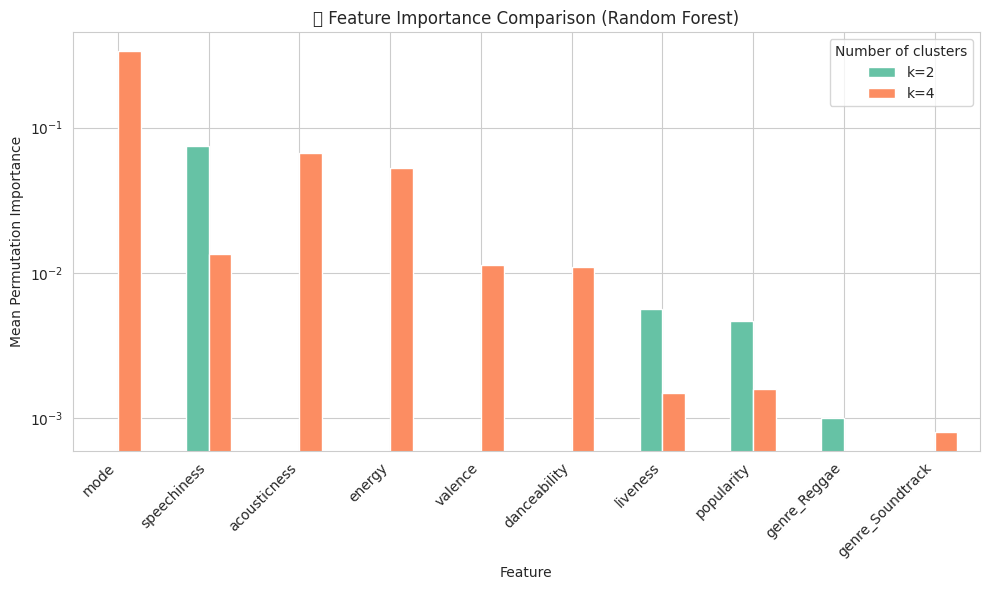

In [97]:
# ---------------------------------------------
# 5. Random Forest importance for k=2 and k=4 (with one-hot encoding)
# ---------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

def rf_importance_for_k(k_val):
    print(f"\n{'='*60}\n🌲 RANDOM FOREST - k = {k_val}\n{'='*60}")

    # Clustering
    km = KMeans(n_clusters=k_val, random_state=0)
    clusters = km.fit_predict(X_scaled)  # X_scaled contains all features (numeric scaled + binary + one-hot encoded)

    # Feature names from X_final
    feature_names = X_final.columns.tolist()

    # DataFrame with proper column names
    X_full = pd.DataFrame(X_scaled, columns=feature_names)
    X_full[f'cluster_{k_val}'] = clusters

    # Feature matrix and target
    X_feats = X_full.drop(columns=[f'cluster_{k_val}'])
    y = X_full[f'cluster_{k_val}']

    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=200, random_state=0)
    rf.fit(X_feats, y)

    # Permutation importances
    perm = permutation_importance(rf, X_feats, y, n_repeats=10, random_state=0)
    importances = pd.Series(perm.importances_mean, index=X_feats.columns).sort_values(ascending=False)

    print("\n🎯 Permutation Importances (mean):")
    display(importances.head(10))

    return importances

# Calculate importances for k=2 and k=4
importances_k2 = rf_importance_for_k(2)
importances_k4 = rf_importance_for_k(4)

# ---------------------------------------------
# 🔹 Comparative visualization
# ---------------------------------------------
imp_compare = pd.DataFrame({
    'k=2': importances_k2,
    'k=4': importances_k4
}).fillna(0)

top_feats = imp_compare.sum(axis=1).sort_values(ascending=False).head(10).index
imp_top = imp_compare.loc[top_feats]

imp_top.plot(kind='bar', figsize=(10,6), logy=True)
plt.title("🎵 Feature Importance Comparison (Random Forest)")
plt.ylabel("Mean Permutation Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Number of clusters")
plt.tight_layout()
plt.show()

# # 🔹 Separate plot for k=2
# importances_k2.sort_values(ascending=False).head(10).plot(
#     kind='bar', figsize=(8,5), color='steelblue', logy=True
# )
# plt.title("🌲 Feature Importance (k = 2, log scale)")
# plt.ylabel("Mean Permutation Importance (log scale)")
# plt.xlabel("Feature")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# # 🔹 Separate plot for k=4
# importances_k4.sort_values(ascending=False).head(10).plot(
#     kind='bar', figsize=(8,5), color='orange', logy=True
# )
# plt.title("🌲 Feature Importance (k = 4, log scale)")
# plt.ylabel("Mean Permutation Importance (log scale)")
# plt.xlabel("Feature")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()



## **9. Scatter Plots of Top Features**

We visualize clusters for **k = 2 and k = 4**





📊 Scatter plots for k = 2
Selected numeric features for visualization (k=2): ['speechiness', 'liveness']


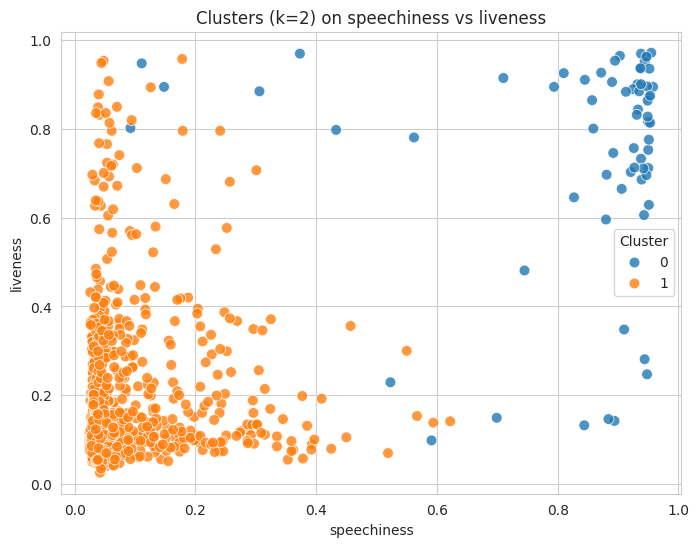


📊 Scatter plots for k = 4
Selected numeric features for visualization (k=4): ['acousticness', 'energy']


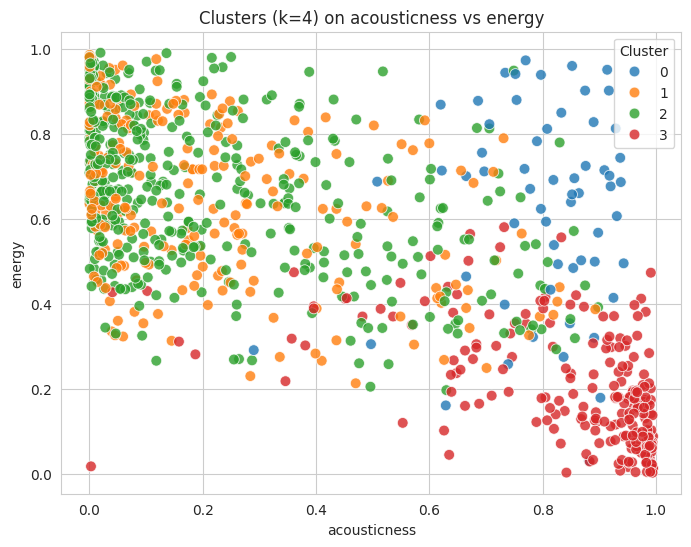

In [98]:
# ---------------------------------------------
# 6. Scatter plots for the most relevant numeric features (k=2 and k=4)
# ---------------------------------------------

# Re-run clustering to ensure clusters are updated
km_k2 = KMeans(n_clusters=2, random_state=0)
X['cluster_2'] = km_k2.fit_predict(X_scaled)

km_k4 = KMeans(n_clusters=4, random_state=0)
X['cluster_4'] = km_k4.fit_predict(X_scaled)

# Function to generate scatter plots using numeric features only
def plot_clusters_numeric(k_val, importances, X_data):
    print(f"\n📊 Scatter plots for k = {k_val}")

    # Select top numeric features (ignore binary/categorical)
    numeric_feats = [f for f in importances.index if f in numeric_features]
    top_features = numeric_feats[:2]

    print(f"Selected numeric features for visualization (k={k_val}):", top_features)

    if len(top_features) < 2:
        print(f"Not enough numeric features to plot scatter for k={k_val}.")
        return

    # Scatter plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_data[top_features[0]],
        y=X_data[top_features[1]],
        hue=X_data[f'cluster_{k_val}'],
        palette='tab10',
        s=60,
        alpha=0.8
    )
    plt.title(f"Clusters (k={k_val}) on {top_features[0]} vs {top_features[1]}")
    plt.xlabel(top_features[0])
    plt.ylabel(top_features[1])
    plt.legend(title='Cluster')
    plt.show()


# Plot for k=2
plot_clusters_numeric(2, importances_k2, X)

# Plot for k=4
plot_clusters_numeric(4, importances_k4, X)


## **10. Numeric Feature Visualizations**

For each cluster (k = 2 and k = 4), we visualize the distribution of numeric features:  

- **Boxplots** show the spread and median of each feature per cluster.  
- **Histograms** show the overall distribution and how points are divided among clusters.  
  



📊 VISUALIZATIONS FOR k = 2


/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




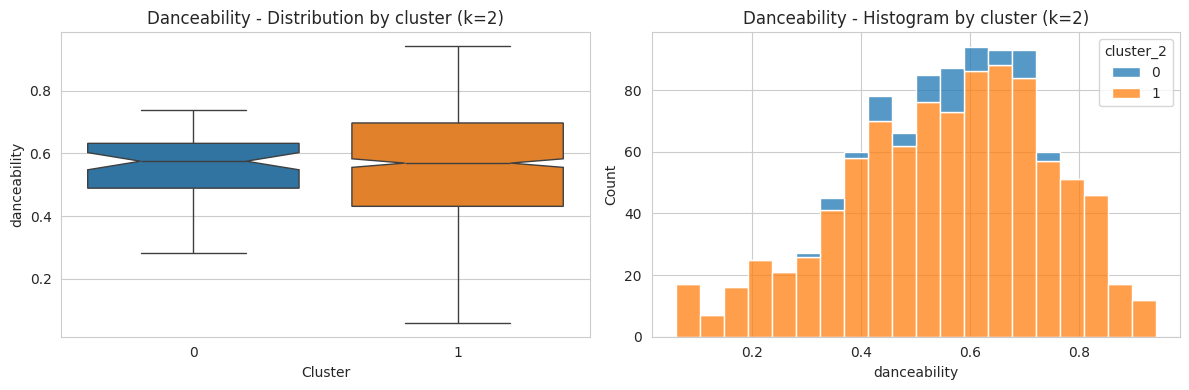

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




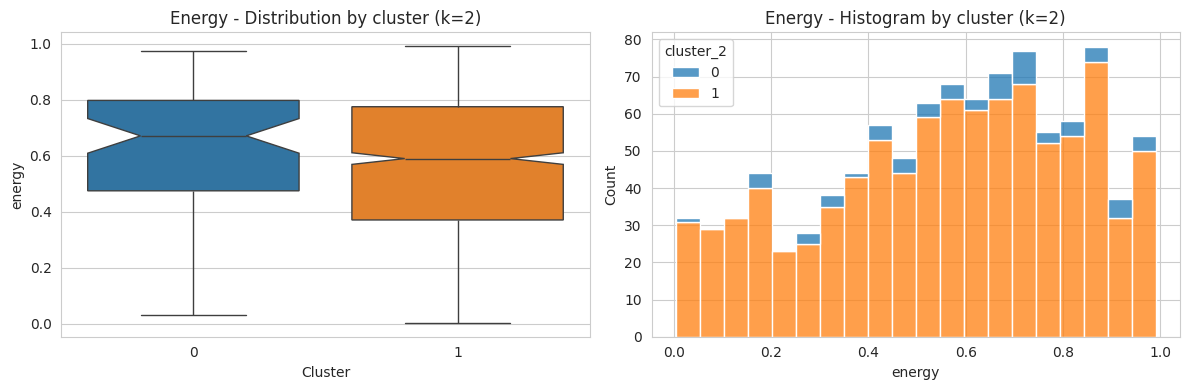

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




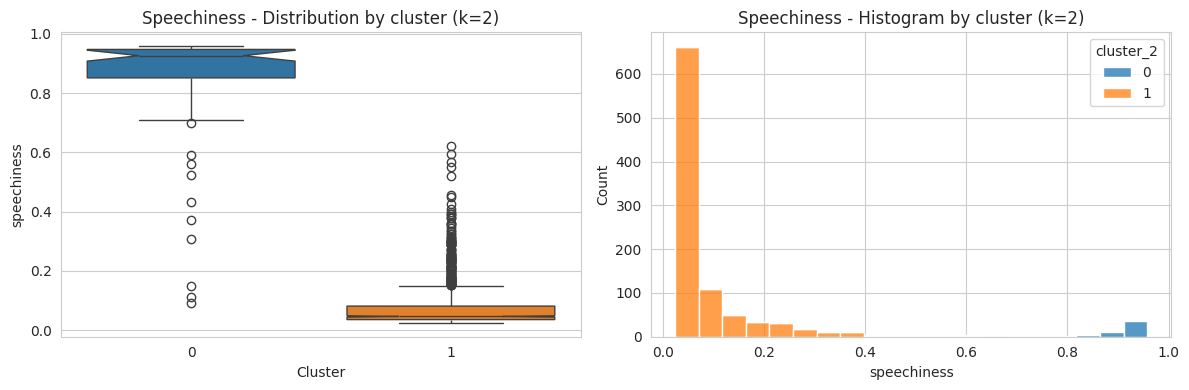

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




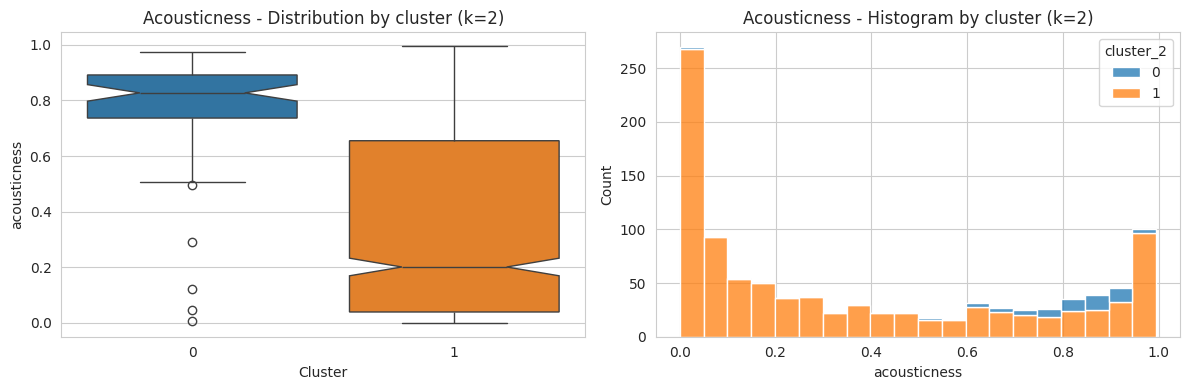

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




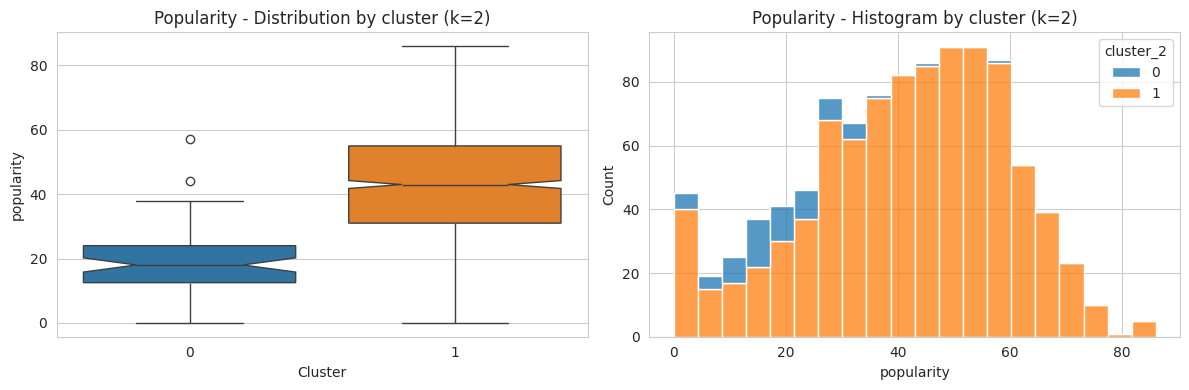

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




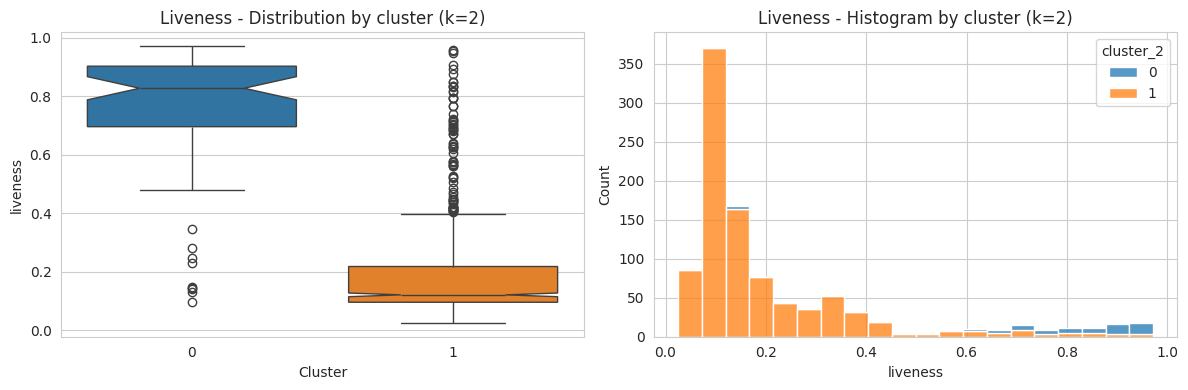

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




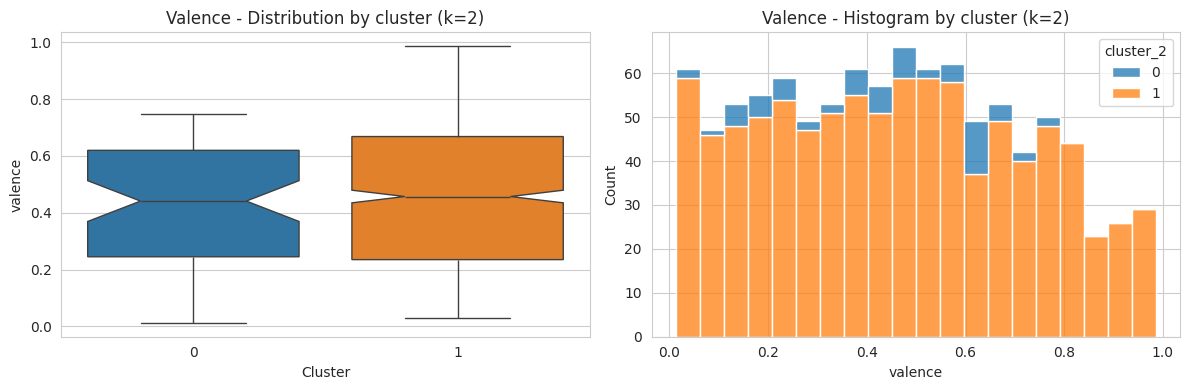

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




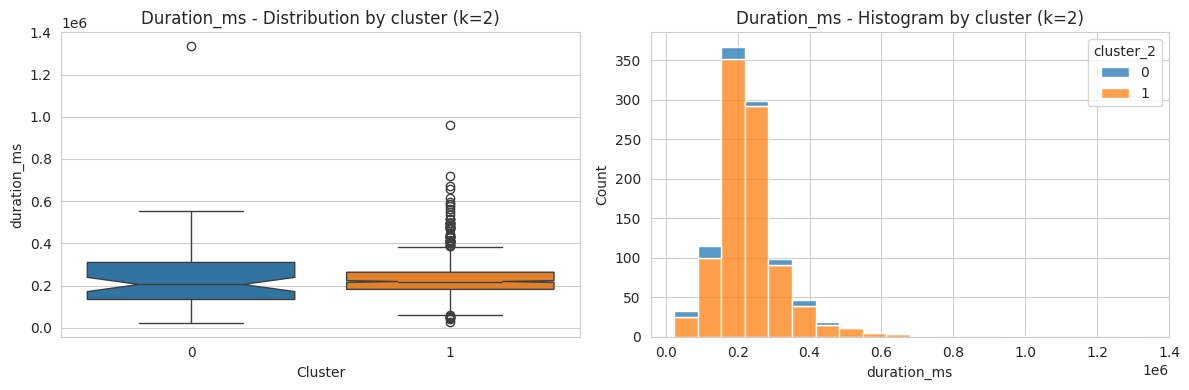


📊 VISUALIZATIONS FOR k = 4


/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




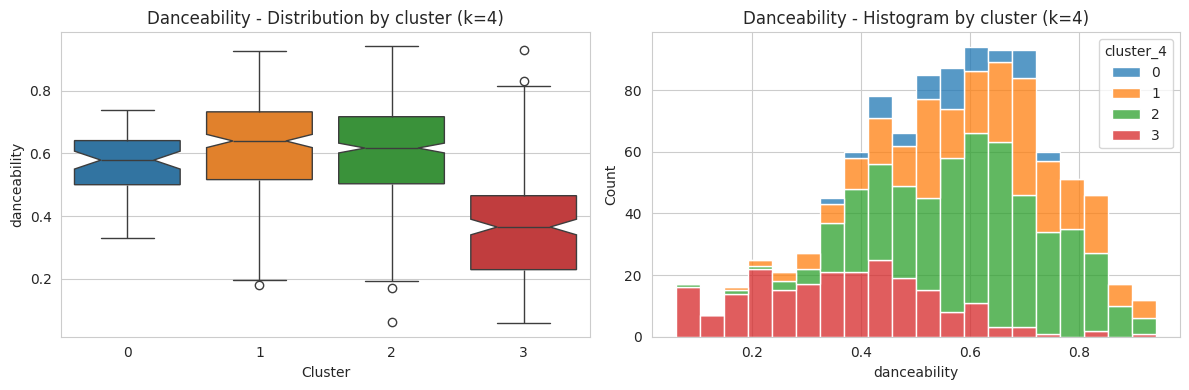

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




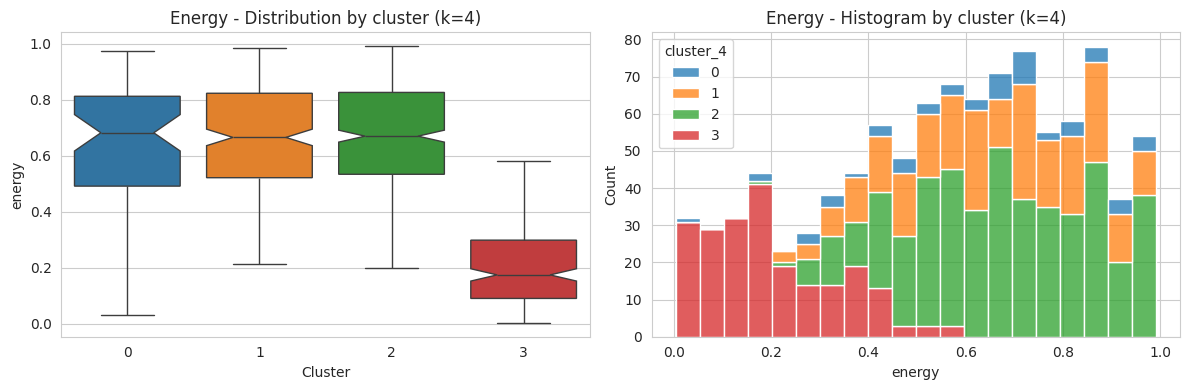

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




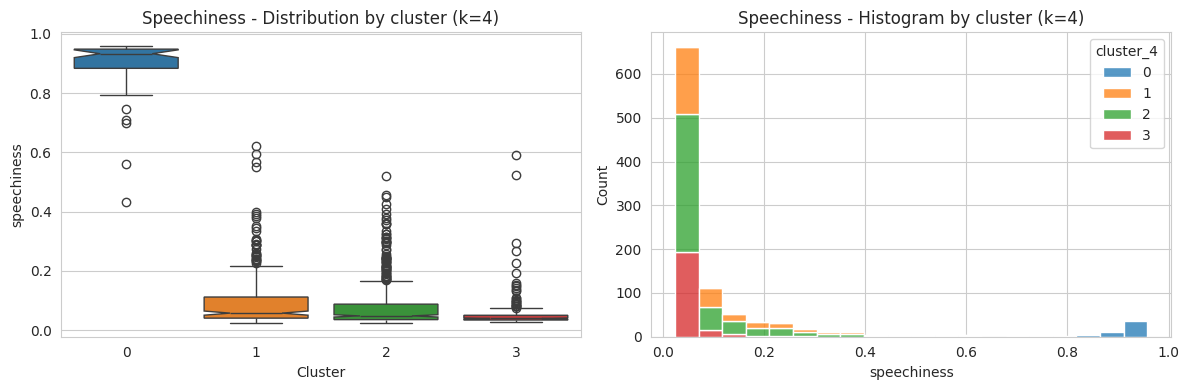

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




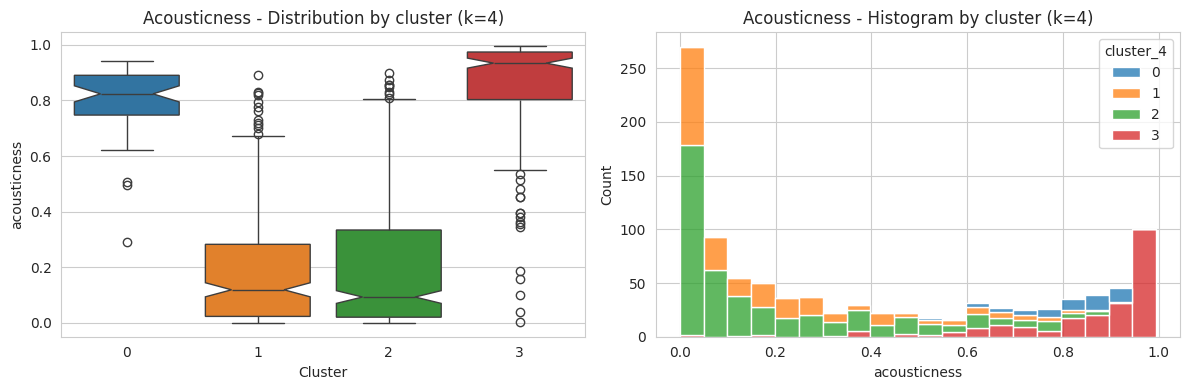

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




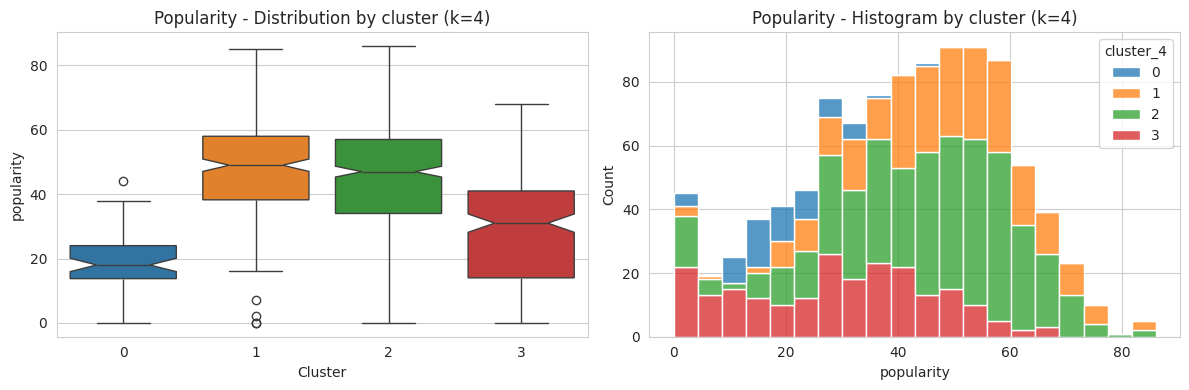

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




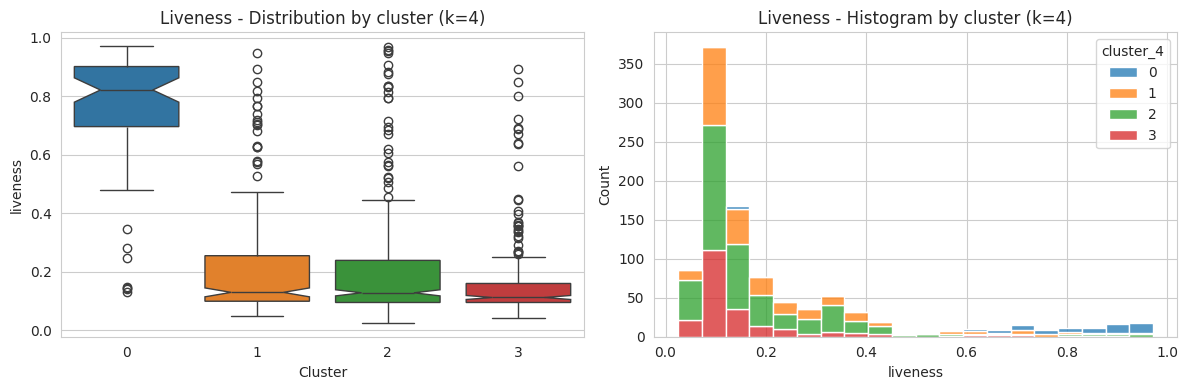

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




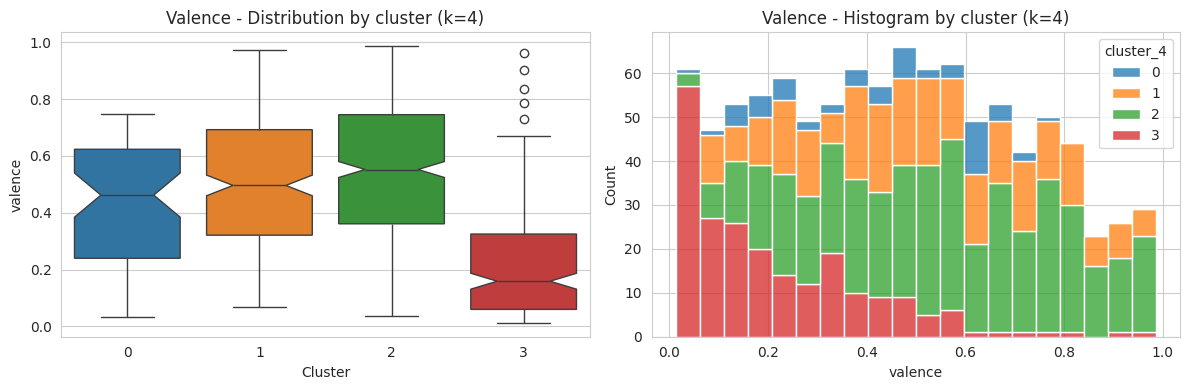

/tmp/ipython-input-765092612.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




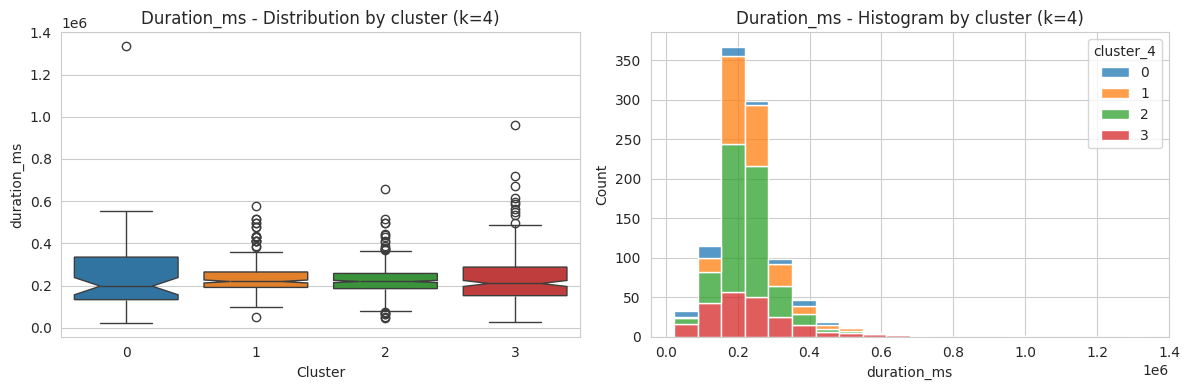

In [99]:
# ---------------------------------------------
# 7. Visualizations for numeric features (k=2 and k=4)
# ---------------------------------------------
def plot_visualizations_for_k(k_val, X_data):
    print(f"\n{'='*60}\n📊 VISUALIZATIONS FOR k = {k_val}\n{'='*60}")

    # Numeric columns to visualize (excluding 'mode')
    numeric_cols_to_plot = [
        'danceability', 'energy', 'speechiness', 'acousticness',
        'popularity', 'liveness', 'valence', 'duration_ms'
    ]

    for col in numeric_cols_to_plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Prepare data for plotting
        plot_data = X[[col, f'cluster_{k_val}']].copy()

        # Boxplot by cluster
        sns.boxplot(
            x=f'cluster_{k_val}',
            y=col,
            data=plot_data,
            ax=axes[0],
            palette='tab10',  # nicer palette
            notch=True
        )
        axes[0].set_title(f"{col.capitalize()} - Distribution by cluster (k={k_val})")
        axes[0].set_xlabel("Cluster")
        axes[0].set_ylabel(col)

        # Histogram by cluster
        sns.histplot(
            data=plot_data,
            x=col,
            hue=f'cluster_{k_val}',
            multiple='stack',
            bins=20,
            ax=axes[1],
            palette='tab10'
        )
        axes[1].set_title(f"{col.capitalize()} - Histogram by cluster (k={k_val})")
        axes[1].set_xlabel(col)
        axes[1].set_ylabel("Count")

        plt.tight_layout()
        plt.show()


# Visualizations for k=2
plot_visualizations_for_k(2, X)

# Visualizations for k=4
plot_visualizations_for_k(4, X)


## **11. Sankey Diagram: Cluster Transitions**

  


In [100]:
# ---------------------------------------------
# 8. Sankey Diagram with Plasma palette (k=2 vs k=4)
# ---------------------------------------------
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.pyplot as plt

if 'cluster_2' not in X.columns or 'cluster_4' not in X.columns:
    print("Columns 'cluster_2' or 'cluster_4' are not present in X. Please re-run clustering cells.")
else:
    sankey_data = X.groupby(['cluster_2', 'cluster_4']).size().reset_index(name='count')

    max_clusters = max(X['cluster_2'].nunique(), X['cluster_4'].nunique())

    # Plasma colormap
    plasma = plt.get_cmap('coolwarm', max_clusters)

    # Base colors for k=2 clusters
    k2_unique = sorted(X['cluster_2'].unique())
    k2_colors = [f'rgba({int(r*255)},{int(g*255)},{int(b*255)},1)'
                 for r,g,b,_ in plasma(range(len(k2_unique)))]

    # Shades for k=4 clusters based on parent k=2
    cluster4_colors = {}
    for i, k2 in enumerate(k2_unique):
        k4_children = sorted(X[X['cluster_2']==k2]['cluster_4'].unique())
        for j, k4 in enumerate(k4_children):
            alpha = 0.6 + 0.4*(j/len(k4_children))
            cluster4_colors[k4] = k2_colors[i].replace('1)', f'{alpha})')  # Adjust alpha

    # Node labels and colors
    labels = [f'k=2 - Cluster {c}' for c in k2_unique] + [f'k=4 - Cluster {c}' for c in sorted(X['cluster_4'].unique())]
    node_colors = k2_colors + [cluster4_colors[c] for c in sorted(X['cluster_4'].unique())]

    # Source and target indices
    source_indices = [k2_unique.index(row['cluster_2']) for _, row in sankey_data.iterrows()]
    target_indices = [len(k2_unique) + sorted(X['cluster_4'].unique()).index(row['cluster_4']) for _, row in sankey_data.iterrows()]
    values = sankey_data['count'].tolist()

    # Link colors based on parent k=2 cluster
    link_colors = [k2_colors[source_indices[i]] for i in range(len(source_indices))]

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source_indices,
            target=target_indices,
            value=values,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text="Sankey Diagram: Track Flow between k=2 and k=4 Clusters (Plasma Colors)",
        font_size=10
    )
    fig.show()
